In [1]:
import pandas as pd
import glob
import sys 
import os 
import cellphonedb
import anndata
import seaborn as sns
import scanpy as sc
from scipy.sparse import csr_matrix, issparse

import numpy as np
from matplotlib import pyplot as plt
import logging
from scipy.sparse import issparse

# A. tutorial for installing CellPhoneDB database

In [2]:
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

In [3]:
#defining the version of the download and the path
cpdb_version = 'v5.0.0'


In [4]:
os.getcwd()

'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Analysis'

In [5]:
# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/CellPhoneDB', cpdb_version)

In [6]:
from cellphonedb.utils import db_utils

#db_utils.download_database(cpdb_target_dir, cpdb_version)

# B. CellphoneDB method 1

### 2.1 Get the cell type file (named meta_file_path in tutorial) 

In [7]:
adata_L1_1 = anndata.read_h5ad('CellPhoneDB/anndata/lung_L1_1.h5ad')
ad_L1_1_cell_type = adata_L1_1.obs["singler_annotation"]
ad_L1_1_cell_type_df = ad_L1_1_cell_type.to_frame()
ad_L1_1_cell_type_df.reset_index(inplace=True)
ad_L1_1_cell_type_df.rename(columns={"singler_annotation":'cell_type', "index":'barcode_sample'}, inplace=True)
ad_L1_1_cell_type_df.shape

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'CellPhoneDB/anndata/lung_L1_1.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [8]:
os.getcwd()

'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Analysis'

In [9]:
#export 
#filepath = "CellPhoneDB/ad_L1_1_cell_type.tsv"
#ad_L1_1_cell_type_df.to_csv(filepath, sep='\t', index=False)

### 2.2 Get the normalised log counts

logcounts_matrix = adata_L1_1.layers['logcounts']

gene_names = adata_L1_1.var_names
cell_ids = adata_L1_1.obs_names

logcounts_df = pd.DataFrame.sparse.from_spmatrix(logcounts_matrix.T, index=gene_names, columns=cell_ids)
L1_1_logcounts_df = logcounts_df.T
L1_1_logcounts_df.shape

#Create an AnnData object
adata = anndata.AnnData(L1_1_logcounts_df)

#set the index correctly 
meta_file_path = 'CellPhoneDB/ad_L1_1_cell_type.tsv'
metadata = pd.read_csv(meta_file_path, sep = '\t')
adata.obs.index = metadata['barcode_sample']

#save as logcounts.h5ad
adata.write('CellPhoneDB/logcounts.h5ad')


#### Exploring normalisation of the counts :
- Look at the log counts ()
- Look at the raw count
- look at the Pearson version (implemented in scanpy) ? Look a the other methods given Jieran 

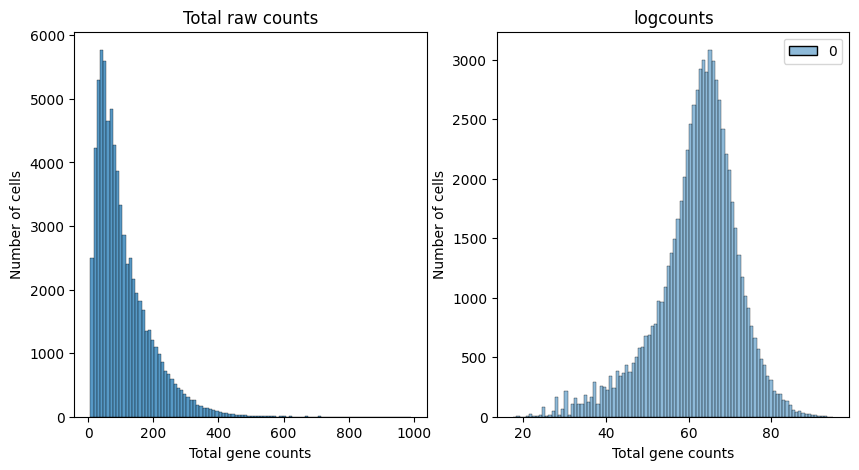

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata_L1_1.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total raw counts")
axes[0].set_xlabel("Total gene counts")
axes[0].set_ylabel("Number of cells")

p2 = sns.histplot(
    adata_L1_1.layers["logcounts"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("logcounts")
axes[1].set_xlabel("Total gene counts")
axes[1].set_ylabel("Number of cells")

plt.show()



#Change the name of the axis, y : number of cells 
#Change X : total_genes_counts

In [132]:
#analytic_pearson_residuals
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata_L1_1, inplace=False)
adata_L1_1.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

In [134]:
# log1p transform
scales_counts = sc.pp.normalize_total(adata_L1_1, target_sum=None, inplace=False)
adata_L1_1.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

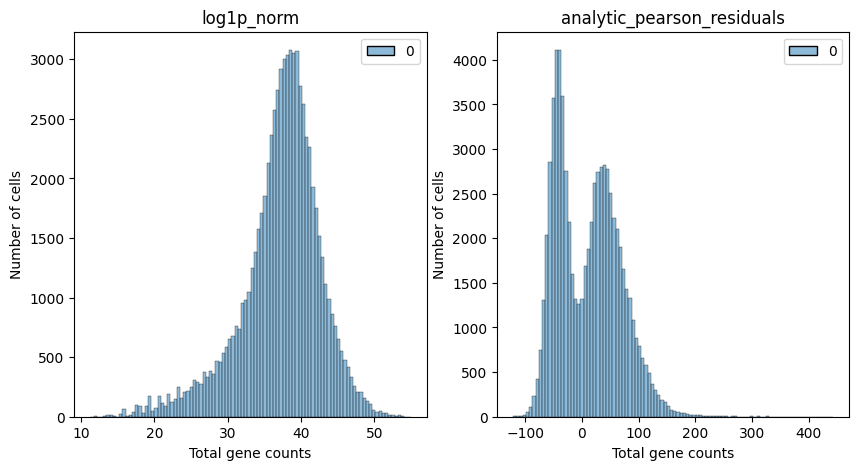

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata_L1_1.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("log1p_norm")
axes[0].set_xlabel("Total gene counts")
axes[0].set_ylabel("Number of cells")

p2 = sns.histplot(adata_L1_1.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("analytic_pearson_residuals")
axes[1].set_xlabel("Total gene counts")
axes[1].set_ylabel("Number of cells")

plt.show()

### 3. Get Microenvironments

add underneath with the cell type, then select for unique cell_type / seurat_clusters conbinations

In [42]:
meta_file_path = 'CellPhoneDB/ad_L1_1_cell_type.tsv'
ad_L1_1_cell_type_df = pd.read_csv(meta_file_path, sep='\t')

In [43]:
seurat_clusters_df = adata_L1_1.obs['seurat_clusters'].to_frame()
seurat_clusters_df['barcode_sample'] = seurat_clusters_df.index
seurat_clusters_df.reset_index(drop=True, inplace=True)

In [44]:
ad_L1_1_microenvs_df = pd.concat([ad_L1_1_cell_type_df, seurat_clusters_df], axis=1)
ad_L1_1_microenvs_df.drop(columns=ad_L1_1_microenvs_df.columns[3], inplace=True)
ad_L1_1_microenvs_df.drop_duplicates(subset=['cell_type', 'seurat_clusters'], keep='first', inplace=True)
ad_L1_1_microenvs_df.reset_index(drop=True, inplace=True)
ad_L1_1_microenvs_df

,cell_type,seurat_clusters
0,Tu_L1_SFTPB,0
1,Tu_L1_SFTPB,2
2,Tu_L1_SFTPB,8
3,Endothelia,9
4,Tu_L1_SFTPB,17
...,...,...
440,T_regs,7
441,T_regs,9
442,T_regs,16
443,Plasma cell_IGHG3,12


In [45]:
file_path = 'CellPhoneDB/ad_L1_1_microenvs.tsv'
ad_L1_1_microenvs_df.to_csv(file_path, sep='\t', index=False)

/tmp/ipykernel_4035424/3562977220.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_per_cluster = ad_L1_1_microenvs_df.groupby('seurat_clusters')['singler_annotation'].nunique()


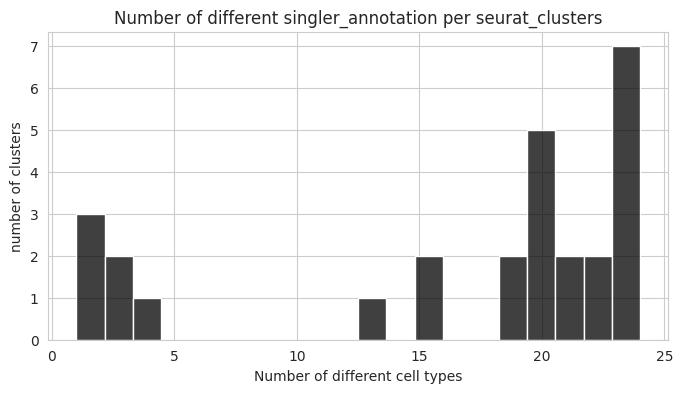

In [11]:
counts_per_cluster = ad_L1_1_microenvs_df.groupby('seurat_clusters')['cell_type'].nunique()

sns.set_style("whitegrid")

plt.figure(figsize=(8, 4))
sns.histplot(counts_per_cluster, bins=20, kde=False, color="black" )
plt.xlabel('Number of different cell types')
plt.ylabel('number of clusters')
plt.title('Number of different singler_annotation per seurat_clusters')
plt.show()

### 3.1 Run Basic Analysis without microenvs

#### Stat analysis

In [46]:
DB_V5_file_path = 'CellPhoneDB/v5.0.0/cellphonedb.zip'
meta_file_path = 'CellPhoneDB/ad_L1_1_cell_type.tsv'
counts_file_path = 'CellPhoneDB/logcounts.h5ad'
out_path = 'CellPhoneDB/Basic_Analysis/method_1/'
microenvs_file_path = 'CellPhoneDB/ad_L1_1_microenvs.tsv'

In [14]:
from cellphonedb.src.core.methods import cpdb_analysis_method

cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path = DB_V5_file_path,           # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,           # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,       # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',               # defines the gene annotation in counts matrix.
    score_interactions = True,                 # optional: whether to score interactions or not. 
    output_path = out_path,                    # Path to save results    microenvs_file_path = None,
    separator = '|',                           # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    threads = 5,                               # number of threads to use in the analysis.
    threshold = 0.1,                           # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
    debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_suffix = None                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
)

[ ][CORE][07/02/24-17:36:27][INFO] [Non Statistical Method] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
CellPhoneDB/logcounts.h5ad
CellPhoneDB/ad_L1_1_cell_type.tsv
[ ][CORE][07/02/24-17:36:30][INFO] Running Basic Analysis
[ ][CORE][07/02/24-17:36:30][INFO] Building results
[ ][CORE][07/02/24-17:36:30][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 24/24 [00:00<00:00, 81.21it/s]

[ ][CORE][07/02/24-17:36:31][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 24/24 [00:00<00:00, 453.95it/s]

[ ][CORE][07/02/24-17:36:31][INFO] Scoring interactions: Calculating scores for all interactions and cell types..



/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/cellphonedb/utils/scoring_utils.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  matrix[index_name].replace(to_replace=id2name, inplace=True)
100%|██████████| 576/576 [00:01<00:00, 518.35it/s]


Saved means_result to CellPhoneDB/Basic_Analysis/method_1/simple_analysis_means_result_02_07_2024_173632.txt
Saved deconvoluted to CellPhoneDB/Basic_Analysis/method_1/simple_analysis_deconvoluted_02_07_2024_173632.txt
Saved deconvoluted_percents to CellPhoneDB/Basic_Analysis/method_1/simple_analysis_deconvoluted_percents_02_07_2024_173632.txt
Saved interaction_scores to CellPhoneDB/Basic_Analysis/method_1/simple_analysis_interaction_scores_02_07_2024_173632.txt


In [15]:
print(cpdb_results.keys())

dict_keys(['means_result', 'deconvoluted', 'deconvoluted_percents', 'interaction_scores'])


In [17]:
cpdb_results['means_result'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,Tu_L1_SFTPB|Pericytes,Tu_L1_SFTPB|Plasma cell_IGHA1,Tu_L1_SFTPB|Plasma cell_IGHG3,Tu_L1_SFTPB|Plasma cell_IGHM,Tu_L1_SFTPB|Plasma cell_IGKC,Tu_L1_SFTPB|Smooth_muscle,Tu_L1_SFTPB|T_CD4,Tu_L1_SFTPB|T_CTL,Tu_L1_SFTPB|T_regs,Tu_L1_SFTPB|Tu_L1_SFTPB
304,CPI-SS0ACFA4F22,GJA5_GJA5,simple:P36382,simple:P36382,GJA5,GJA5,False,False,False,curated,...,0.134,0.042,0.045,0.052,0.049,0.104,0.042,0.060,0.035,0.022
644,CPI-SS0E3AA6B7B,NTN4_NTRK2,simple:Q9HB63,simple:Q16620,NTN4,NTRK2,True,False,True,curated,...,0.074,0.053,0.077,0.062,0.062,0.087,0.056,0.055,0.052,0.034


#### Basic Analaysis and Ploting

In [58]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

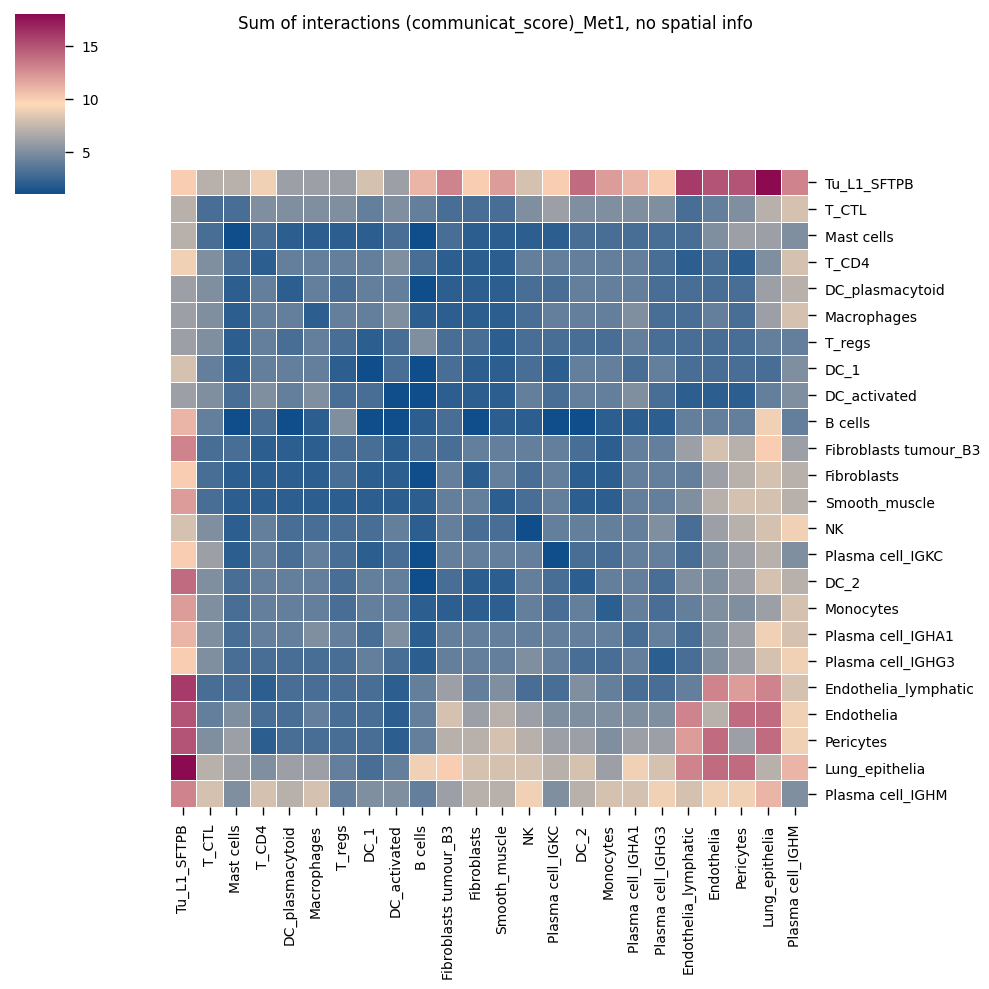

In [59]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['means_result'],
                      degs_analysis = False,
                      figsize = (10, 10),
                      title = "Sum of interactions (communicat_score)_Met1, no spatial info")

### 3.2 Run Basic Analysis with microenvs

In [145]:
from cellphonedb.src.core.methods import cpdb_analysis_method

cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path = DB_V5_file_path,           # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,           # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,       # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',               # defines the gene annotation in counts matrix.
    microenvs_file_path = None, # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                 # optional: whether to score interactions or not. 
    output_path = out_path,                    # Path to save results    microenvs_file_path = None,
    separator = '|',                           # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    threads = 5,                               # number of threads to use in the analysis.
    threshold = 0.1,                           # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
    debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_suffix = None                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
)

[ ][CORE][08/02/24-15:02:32][INFO] [Non Statistical Method] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
CellPhoneDB/logcounts.h5ad
CellPhoneDB/ad_L1_1_cell_type.tsv
[ ][CORE][08/02/24-15:02:32][INFO] Running Basic Analysis
[ ][CORE][08/02/24-15:02:32][INFO] Building results
[ ][CORE][08/02/24-15:02:33][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 24/24 [00:00<00:00, 66.91it/s]

[ ][CORE][08/02/24-15:02:33][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 24/24 [00:00<00:00, 323.18it/s]

[ ][CORE][08/02/24-15:02:33][INFO] Scoring interactions: Calculating scores for all interactions and cell types..



100%|██████████| 576/576 [00:01<00:00, 374.16it/s]


Saved means_result to CellPhoneDB/Basic_Analysis/method_1/simple_analysis_means_result_02_08_2024_150235.txt
Saved deconvoluted to CellPhoneDB/Basic_Analysis/method_1/simple_analysis_deconvoluted_02_08_2024_150235.txt
Saved deconvoluted_percents to CellPhoneDB/Basic_Analysis/method_1/simple_analysis_deconvoluted_percents_02_08_2024_150235.txt
Saved interaction_scores to CellPhoneDB/Basic_Analysis/method_1/simple_analysis_interaction_scores_02_08_2024_150235.txt


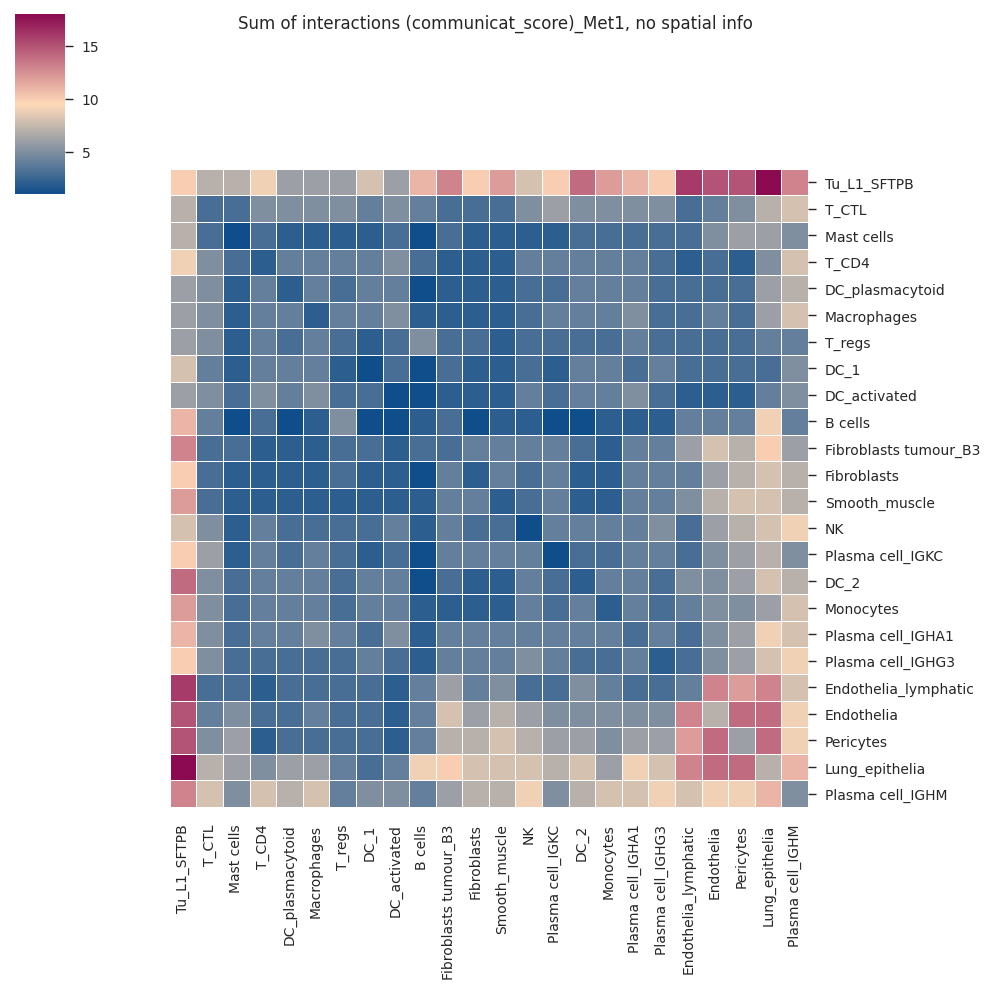

In [147]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['means_result'],
                      degs_analysis = False,
                      figsize = (10, 10),
                      title = "Sum of interactions (communicat_score)_Met1, no spatial info")

## 4 Run Method 2 with p values  

### 4.1 Method 2 without microenvs

#### Analysis 

#### Plots

### 4.2 Method 2 with micro envs

#### Analysis 

In [143]:
t = 1

In [144]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = DB_V5_file_path,                 # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    #active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    microenvs_file_path = None,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 5,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
CellPhoneDB/logcounts.h5ad
CellPhoneDB/ad_L1_1_cell_type.tsv
[ ][CORE][08/02/24-15:01:34][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:5 Precision:3
[ ][CORE][08/02/24-15:01:34][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][08/02/24-15:01:34][INFO] Running Real Analysis
[ ][CORE][08/02/24-15:01:34][INFO] Running Statistical Analysis


  5%|▌         | 50/1000 [00:10<03:24,  4.65it/s]Process ForkPoolWorker-76:
Process ForkPoolWorker-77:
Process ForkPoolWorker-80:
Process ForkPoolWorker-78:
Process ForkPoolWorker-79:



KeyboardInterrupt: 

#### Plots

In [63]:
cpdb_results['pvalues']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,T_CTL|Plasma cell_IGHM,T_CTL|B cells,NK|Plasma cell_IGHM,NK|B cells,Plasma cell_IGHG3|B cells,Plasma cell_IGHM|T_CTL,Plasma cell_IGHM|NK,B cells|T_CTL,B cells|NK,B cells|Plasma cell_IGHG3
304,CPI-SS0ACFA4F22,GJA5_GJA5,simple:P36382,simple:P36382,GJA5,GJA5,False,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
644,CPI-SS0E3AA6B7B,NTN4_NTRK2,simple:Q9HB63,simple:Q16620,NTN4,NTRK2,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
766,CPI-SS0C2437E0D,CXCL13_CXCR5,simple:O43927,simple:P32302,CXCL13,CXCR5,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
913,CPI-SS052119104,AREG_EGFR,simple:P15514,simple:P00533,AREG,EGFR,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1999,CPI-SS00D1CB372,CD34_SELL,simple:P28906,simple:P14151,CD34,SELL,False,False,False,curated,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2002,CPI-SS038E5B8D9,CD24_SELP,simple:P25063,simple:P16109,CD24,SELP,False,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2003,CPI-SS013E6EBC3,CD34_SELP,simple:P28906,simple:P16109,CD34,SELP,False,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2338,CPI-SS0D168412F,FASLG_FAS,simple:P48023,simple:P25445,FASLG,FAS,True,False,True,curated,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2762,CPI-SS0C95AC883,WNT2_SFRP2,simple:P09544,simple:Q96HF1,WNT2,SFRP2,True,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2848,CPI-SS0D7DB794A,CD274_CD80,simple:Q9NZQ7,simple:P33681,CD274,CD80,False,True,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


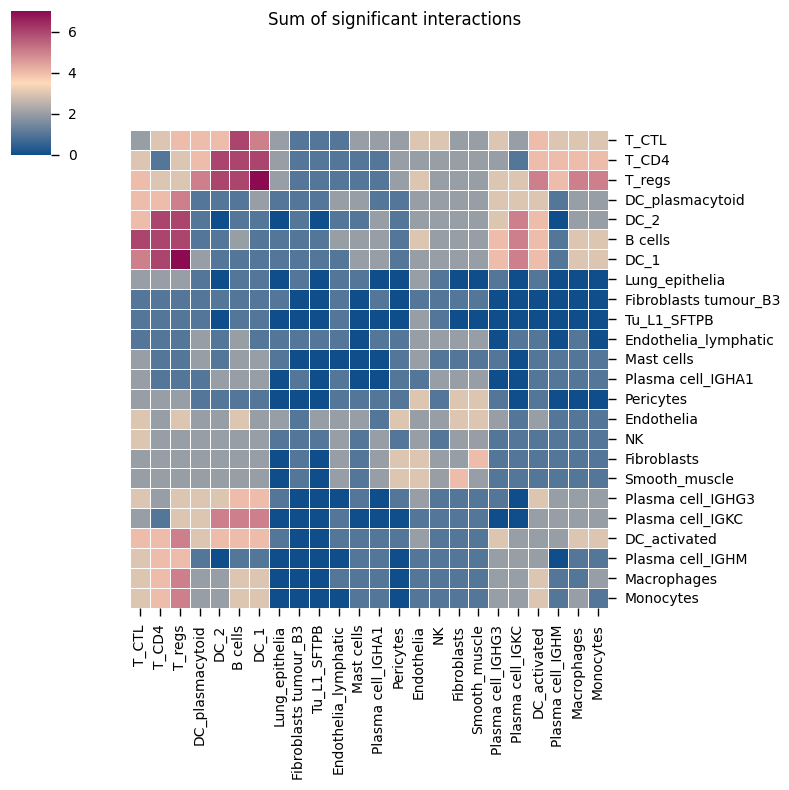

In [65]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['pvalues'],
                      degs_analysis = False,
                      figsize = (8, 8),
                      title = "Sum of significant interactions")

In [ ]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "PV MYH11|PV STEAP4|PV MMPP11",
    cell_type2 = "EVT_1|EVT_2|GC|iEVT|eEVT|VCT_CCC",
    means = cpdb_results['means'],
    pvals = cpdb_results['pvalues'],
    celltype_key = "cell_labels",
    genes = ["TGFB2", "CSF1R"],
    figsize = (10, 3),
    title = "Interactions between\nPV and trophoblast",
    max_size = 3,
    highlight_size = 0.75,
    degs_analysis = False,
    standard_scale = True,
    interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores = True
)

## 5.1 Compare with the chuvio_L1_1 panel

#### 5.1 a Preparing the data for the analysis

###### 1. cell type

In [70]:
adata_L1_1_chuvio = anndata.read_h5ad('CellPhoneDB/anndata/chuvio_L1_1.h5ad')
ad_L1_1_chuvio_cell_type = adata_L1_1_chuvio.obs["singler_annotation"]
ad_L1_1_chuvio_cell_type_df = ad_L1_1_chuvio_cell_type.to_frame()
ad_L1_1_chuvio_cell_type_df.reset_index(inplace=True)
ad_L1_1_chuvio_cell_type_df.rename(columns={"singler_annotation":'cell_type', "index":'barcode_sample'}, inplace=True)
ad_L1_1_chuvio_cell_type_df.shape

(71187, 2)

In [71]:
ad_L1_1_chuvio_cell_type_df

,barcode_sample,cell_type
0,L1_1_aaaadbga-1,Fibroblasts
1,L1_1_aaaajnma-1,Fibroblasts
2,L1_1_aaadecno-1,Pericytes
3,L1_1_aaafkiae-1,Fibroblasts
4,L1_1_aaahijio-1,Pericytes
...,...,...
71182,L1_1_oielkile-1,Fibroblasts
71183,L1_1_oieofjmb-1,Fibroblasts
71184,L1_1_oieokhmm-1,Endothelia_lymphatic
71185,L1_1_oifafdfc-1,Tu_L1_SFTPB


###### 2. counts